# Model Experiments

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [3]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_raw = pd.read_sql_query("""
select
	weather_geo.long,
	weather_geo.lat,
	weather_geo.month,
	weather_geo.date,
	weather_geo.precipitation,
	weather_geo.pressure,
	weather_geo.humidity_2m,
	weather_geo.temp_2m,
	weather_geo.temp_dew_point_2m,
	weather_geo.temp_wet_bulb_2m,
	weather_geo.temp_max_2m,
	weather_geo.temp_min_2m,
	weather_geo.temp_range_2m,
	weather_geo.temp_0m,
	weather_geo.wind_10m,
	weather_geo.wind_max_10m,
	weather_geo.wind_min_10m,
	weather_geo.wind_range_10m,
	weather_geo.wind_50m,
	weather_geo.wind_max_50m,
	weather_geo.wind_min_50m,
	weather_geo.wind_range_50m,
	weather_geo.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
	ifnull(fires_rollup.prior_fire_0_1_year, 0) as prior_fire_0_1_year,
	ifnull(fires_rollup.prior_fire_1_2_year, 0) as prior_fire_1_2_year,
	ifnull(fires_rollup.prior_fire_2_3_year, 0) as prior_fire_2_3_year,
	ifnull(fires_rollup.prior_fire_3_4_year, 0) as prior_fire_3_4_year,
	ifnull(fires_rollup.prior_fire_4_5_year, 0) as prior_fire_4_5_year,

  ifnull(fires_rollup.fire_size_class, '') as fire_size_class
from weather_geo
inner join soil
  on soil.fips = weather_geo.fips
left outer join fires_rollup
  on fires_rollup.date = weather_geo.date
  and fires_rollup.long = weather_geo.long
  and fires_rollup.lat = weather_geo.lat
	and fires_rollup.cause in ('Other causes', 'Natural', 'Power', 'Recreation')
where
	weather_geo.day in (1, 6, 11, 16, 21, 26) -- remove once models are stable
""", conn)

conn.close()

df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
long,913824.0,-119.622380,2.509246,-124.25,-121.500000,-120.000000,-117.500000,-114.250000
lat,913824.0,37.251871,2.573236,32.75,35.000000,37.000000,39.500000,42.000000
month,913824.0,6.500000,3.452054,1.00,3.750000,6.500000,9.250000,12.000000
precipitation,913824.0,1.333282,4.843371,0.00,0.000000,0.000000,0.210000,119.330000
pressure,913824.0,91.808033,6.471612,71.19,87.730000,92.650000,97.000000,103.040000
humidity_2m,913824.0,5.247199,2.060564,0.55,3.720000,5.130000,6.590000,17.150000
temp_2m,913824.0,14.500134,9.100449,-18.49,8.000000,13.950000,21.190000,40.510000
temp_dew_point_2m,913824.0,2.070680,6.226852,-21.89,-2.140000,2.580000,6.700000,22.310000
temp_wet_bulb_2m,913824.0,8.285416,6.535384,-19.21,3.900000,8.710000,12.990000,29.230000
temp_max_2m,913824.0,21.834545,10.599562,-12.30,13.970000,21.400000,30.210000,49.440000


In [15]:
final = df_raw.isna().sum()
cols = []
for count, col in zip(final,list(df_raw.columns)):
    if count > 0:
        cols.append(col)

print(f'Columns with null: {cols}')

Columns with null: []


In [8]:
df_fire_false = df_raw[df_raw.fire_size_class == '']
df_fire_true = df_raw[df_raw.fire_size_class != '']
print(f'Unbalanced classes of NO fire: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

df_fire_true_balanced = df_fire_true.sample(n=len(df_fire_false), replace=True)

df_fires = pd.concat([df_fire_false, df_fire_true_balanced], axis=0)
df_fire_false = df_fires[df_fires.fire_size_class == '']
df_fire_true = df_fires[df_fires.fire_size_class != '']
print(f'Balanced classes of NO fires: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

df_fires['has_fire'] = df_fires.fire_size_class > ''

df_fires_numeric = df_fires.drop(['date', 'fire_size_class', 'has_fire'], axis=1)

df_fires_encoded = pd.get_dummies(df_fires_numeric, columns=['month'])

scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.has_fire

num_fires = (df_fires.has_fire == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie Balanced)')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Unbalanced classes of NO fire: 899,550 and YES fire: 14,274
Balanced classes of NO fires: 899,550 and YES fire: 899,550
899550 fires out of 1799100 data points
No fires 50.0% of the time (ie Balanced)


### All Fire Sizes (A-G)

##### LogisticRegression

In [9]:
params={
  'C': [0.1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'All size fires estimator', log_reg.best_estimator_)

y_pred_log_reg = log_reg.predict(X_train)

print('--------- Log Regression Classification ---------')
print(classification_report(y_train, y_pred_log_reg))

All size fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.80      0.77      0.78    675013
        True       0.78      0.81      0.79    674312

    accuracy                           0.79   1349325
   macro avg       0.79      0.79      0.79   1349325
weighted avg       0.79      0.79      0.79   1349325



In [10]:
from sklearn.ensemble import RandomForestClassifier

# params = {
#     'n_estimators': np.arange(40, 100, 20),
#     'max_features': np.arange(4, 12, 1),
#     'max_depth': np.arange(10, 20, 2),
#     'min_samples_split': np.arange(4, 12, 2),
#     'min_samples_leaf': np.arange(2, 10, 2),
#     'max_leaf_nodes': np.arange(4, 10, 2),
# }

# For speed hardcode the latest best guess
params = {'n_estimators': [40], 'min_samples_split': [4], 'min_samples_leaf': [2],
          'max_leaf_nodes': [8], 'max_features': [10], 'max_depth': [18]}

rand_forest = GridSearchCV(RandomForestClassifier(), params, scoring="recall")

rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'max_depth': 18, 'max_features': 10, 'max_leaf_nodes': 8, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 40}
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.75      0.77      0.76    224537
        True       0.76      0.74      0.75    225238

    accuracy                           0.75    449775
   macro avg       0.75      0.75      0.75    449775
weighted avg       0.75      0.75      0.75    449775



Text(0.5, 1.0, 'Random Forest feature importances')

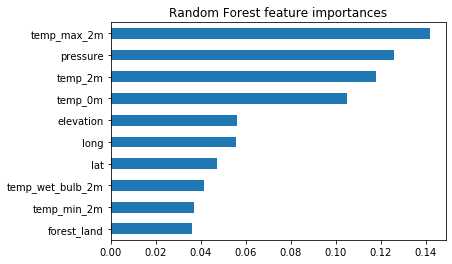

In [11]:
importances_rand_forest = rand_forest.best_estimator_.feature_importances_
importances_rand_forest = pd.Series(importances_rand_forest, index=df_fires_encoded.columns.values).sort_values().tail(10)

fig, ax = plt.subplots()
importances_rand_forest.plot.barh(ax=ax)
ax.set_title('Random Forest feature importances')

In [12]:
import xgboost

params={
  'objective': ['binary:logistic'],
  'max_depth': [5],
  'gamma':[0.5],
  'subsample': [0.5],
  'colsample_bytree': [0.1],
  'colsample_bylevel': [1.0],
  'learning_rate': [0.1, 0.2],
  'n_estimators': [200],
  'eval_metric': ['logloss']
}

xgb = xgboost.XGBClassifier(seed=42, use_label_encoder=False)

xgb = GridSearchCV(estimator=xgb, scoring="recall", param_grid=params)

xgb.fit(X_train, y_train)

print("Best Params:", xgb.best_params_)

Best Params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.1, 'eval_metric': 'logloss', 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.5}


In [13]:
y_pred_xgb = xgb.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.86      0.81      0.84    224537
        True       0.82      0.87      0.84    225238

    accuracy                           0.84    449775
   macro avg       0.84      0.84      0.84    449775
weighted avg       0.84      0.84      0.84    449775



Text(0.5, 1.0, 'XGBoost feature importances')

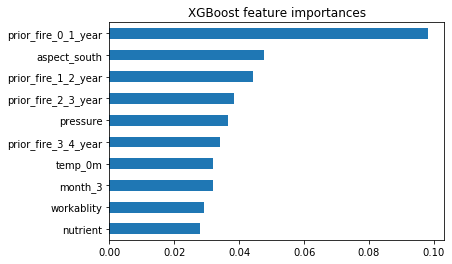

In [14]:
importances_xgb = xgb.best_estimator_.feature_importances_
importances_xgb = pd.Series(importances_xgb, index=df_fires_encoded.columns.values).sort_values().tail(10)

fig, ax = plt.subplots()
importances_xgb.plot.barh(ax=ax)
ax.set_title('XGBoost feature importances')

In [15]:
import lightgbm as lgbm

gbm = lgbm.LGBMClassifier()

# params = {
#   'objective': ['binary'],
#   'metric': ['binary_logloss'],
#   'learning_rate': [0.01, 0.2, 0.4],
#   'num_leaves': [20, 40, 100, 500, 1000, 5000],
#   'max_depth': np.arange(3, 12, 1),
#   'min_data_in_leaf': np.arange(200, 2000, 200),
#   'max_bin': [200, 300],
#   'feature_fraction': np.arange(0.2, 0.9, 0.1),
#   'bagging_fraction': np.arange(0.2, 0.9, 0.1),
#   'bagging_freq': [1, 2, 5],
# }

# For performance use the best params
params = {'objective': ['binary'], 'num_leaves': [5000], 'min_data_in_leaf': [800], 'metric': ['binary_logloss'], 'max_depth': [6],
          'max_bin': [200], 'learning_rate': [0.8], 'feature_fraction': [0.2], 'bagging_freq': [1], 'bagging_fraction': [0.7]}

gbm = RandomizedSearchCV(estimator=gbm, param_distributions=params, scoring="recall", cv=3)
gbm.fit(X_train, y_train)


/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=800, min_

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': [0.7],
                                        'bagging_freq': [1],
                                        'feature_fraction': [0.2],
                                        'learning_rate': [0.8],
                                        'max_bin': [200], 'max_depth': [6],
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': [800],
                                        'num_leaves': [5000],
                                        'objective': ['binary']},
                   scoring='recall')

In [16]:
print(f'Best params: {gbm.best_params_}')

y_pred_gbm = gbm.predict(X_test)

print('--------- LightGBM Classification Report ---------')
print(classification_report(y_test, y_pred_gbm))

# print('--------- LightGBM Report for Original Training Data ---------')
# y_train_pred_gbm = gbm.predict(X_train)
# print(classification_report(y_train, y_train_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 5000, 'min_data_in_leaf': 800, 'metric': 'binary_logloss', 'max_depth': 6, 'max_bin': 200, 'learning_rate': 0.8, 'feature_fraction': 0.2, 'bagging_freq': 1, 'bagging_fraction': 0.7}
--------- LightGBM Classification Report ---------
              precision    recall  f1-score   support

       False       0.91      0.85      0.88    224537
        True       0.86      0.92      0.89    225238

    accuracy                           0.89    449775
   macro avg       0.89      0.89      0.88    449775
weighted avg       0.89      0.89      0.88    449775



Text(0.5, 1.0, 'LGBM feature importances')

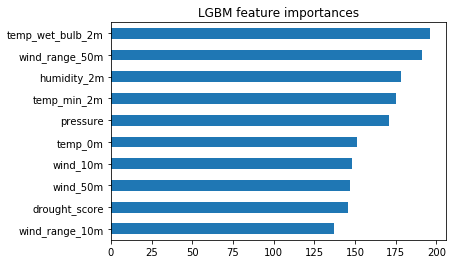

In [17]:
importances_gbm = gbm.best_estimator_.feature_importances_
importances_gbm = pd.Series(importances_gbm, index=df_fires_encoded.columns.values).sort_values().tail(10)

fig, ax = plt.subplots()
importances_gbm.plot.barh(ax=ax)
ax.set_title('LGBM feature importances')

### Only Larger Fire Sizes (10-5000+ arces)

A=0-0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres

In [18]:
df_fires_large_false = df_raw[df_raw.fire_size_class < 'C']
df_fires_large_true = df_raw[df_raw.fire_size_class >= 'C']
print(f'Unbalanced classes of NO fire: {len(df_fires_large_false):,} and YES fire: {len(df_fires_large_true):,}')

df_fires_large_true_balanced = df_fires_large_true.sample(n=len(df_fires_large_false), replace=True)

df_fires_large = pd.concat([df_fires_large_false, df_fires_large_true_balanced], axis=0)
df_fires_large_false = df_fires_large[df_fires_large.fire_size_class < 'C']
df_fires_large_true = df_fires_large[df_fires_large.fire_size_class >= 'C']
print(f'Balanced classes of NO fires: {len(df_fires_large_false):,} and YES fire: {len(df_fires_large_true):,}')

# Ignore small fires ('', 'A', 'B') for now
df_fires_large['has_fire'] = df_fires_large.fire_size_class >= 'C'

df_fires_large_numeric = df_fires_large.drop(['date', 'fire_size_class', 'has_fire'], axis=1)

df_fires_large_encoded = pd.get_dummies(df_fires_large_numeric, columns=['month'])

scaler = StandardScaler()
scaler.fit(df_fires_large_encoded)

X_large = scaler.transform(df_fires_large_encoded)
y_large = df_fires_large.has_fire

X_large_train, X_large_test, y_large_train, y_large_test = train_test_split(X_large, y_large, random_state=42)

Unbalanced classes of NO fire: 912,412 and YES fire: 1,412
Balanced classes of NO fires: 912,412 and YES fire: 912,412


In [19]:
params={
  'C': [0.1],
}

log_reg_large = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg_large = GridSearchCV(estimator=log_reg_large, param_grid=params, scoring='recall', cv=5)

log_reg_large.fit(X_large_train, y_large_train)

print(f'10+ acre fires estimator', log_reg_large.best_estimator_)

10+ acre fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')


In [20]:
y_large_pred_log_reg = log_reg_large.predict(X_large_train)

print('--------- Log Regression Classification (10+ acre fires) ---------')
print(classification_report(y_large_train, y_large_pred_log_reg))

--------- Log Regression Classification (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.82      0.76      0.79    684577
        True       0.78      0.83      0.80    684041

    accuracy                           0.80   1368618
   macro avg       0.80      0.80      0.80   1368618
weighted avg       0.80      0.80      0.80   1368618



In [21]:
import xgboost

params = {
    'objective': ['binary:logistic'],
    'max_depth': [3, 6, 9],
    'gamma': [0, 0.1, 0.4],
    # 'subsample': [0.5],
    # 'colsample_bytree': [0.1],
    # 'colsample_bylevel': [1.0],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [200],
    'eval_metric': ['logloss']
}
# params = {'eval_metric': ['logloss'], 'gamma': [0], 'learning_rate': [0.1],
#           'max_depth': [9], 'n_estimators': [200], 'objective': ['binary:logistic']}

xgb_large = xgboost.XGBClassifier(seed=42, use_label_encoder=False)
xgb_large = GridSearchCV(estimator=xgb_large, scoring="recall", param_grid=params)

xgb_large.fit(X_large_train, y_large_train)

print("10+ acre best Params:", xgb_large.best_params_)

y_large_pred_xgb = xgb_large.predict(X_large_test)

print('--------- XGBoost Classification Report (10+ acre fires) ---------')
print(classification_report(y_large_test, y_large_pred_xgb))

10+ acre best Params: {'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'objective': 'binary:logistic'}
--------- XGBoost Classification Report (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       1.00      0.98      0.99    227835
        True       0.98      1.00      0.99    228371

    accuracy                           0.99    456206
   macro avg       0.99      0.99      0.99    456206
weighted avg       0.99      0.99      0.99    456206



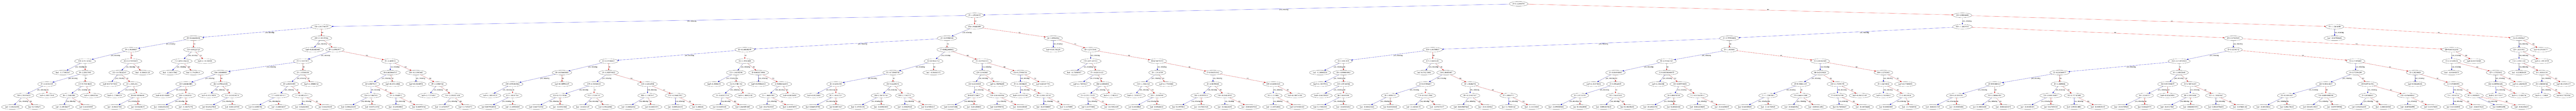

In [7]:
import matplotlib
from xgboost import plot_tree

plot_tree(xgb_large.best_estimator_, num_trees=1)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(300, 200)
plt.show()

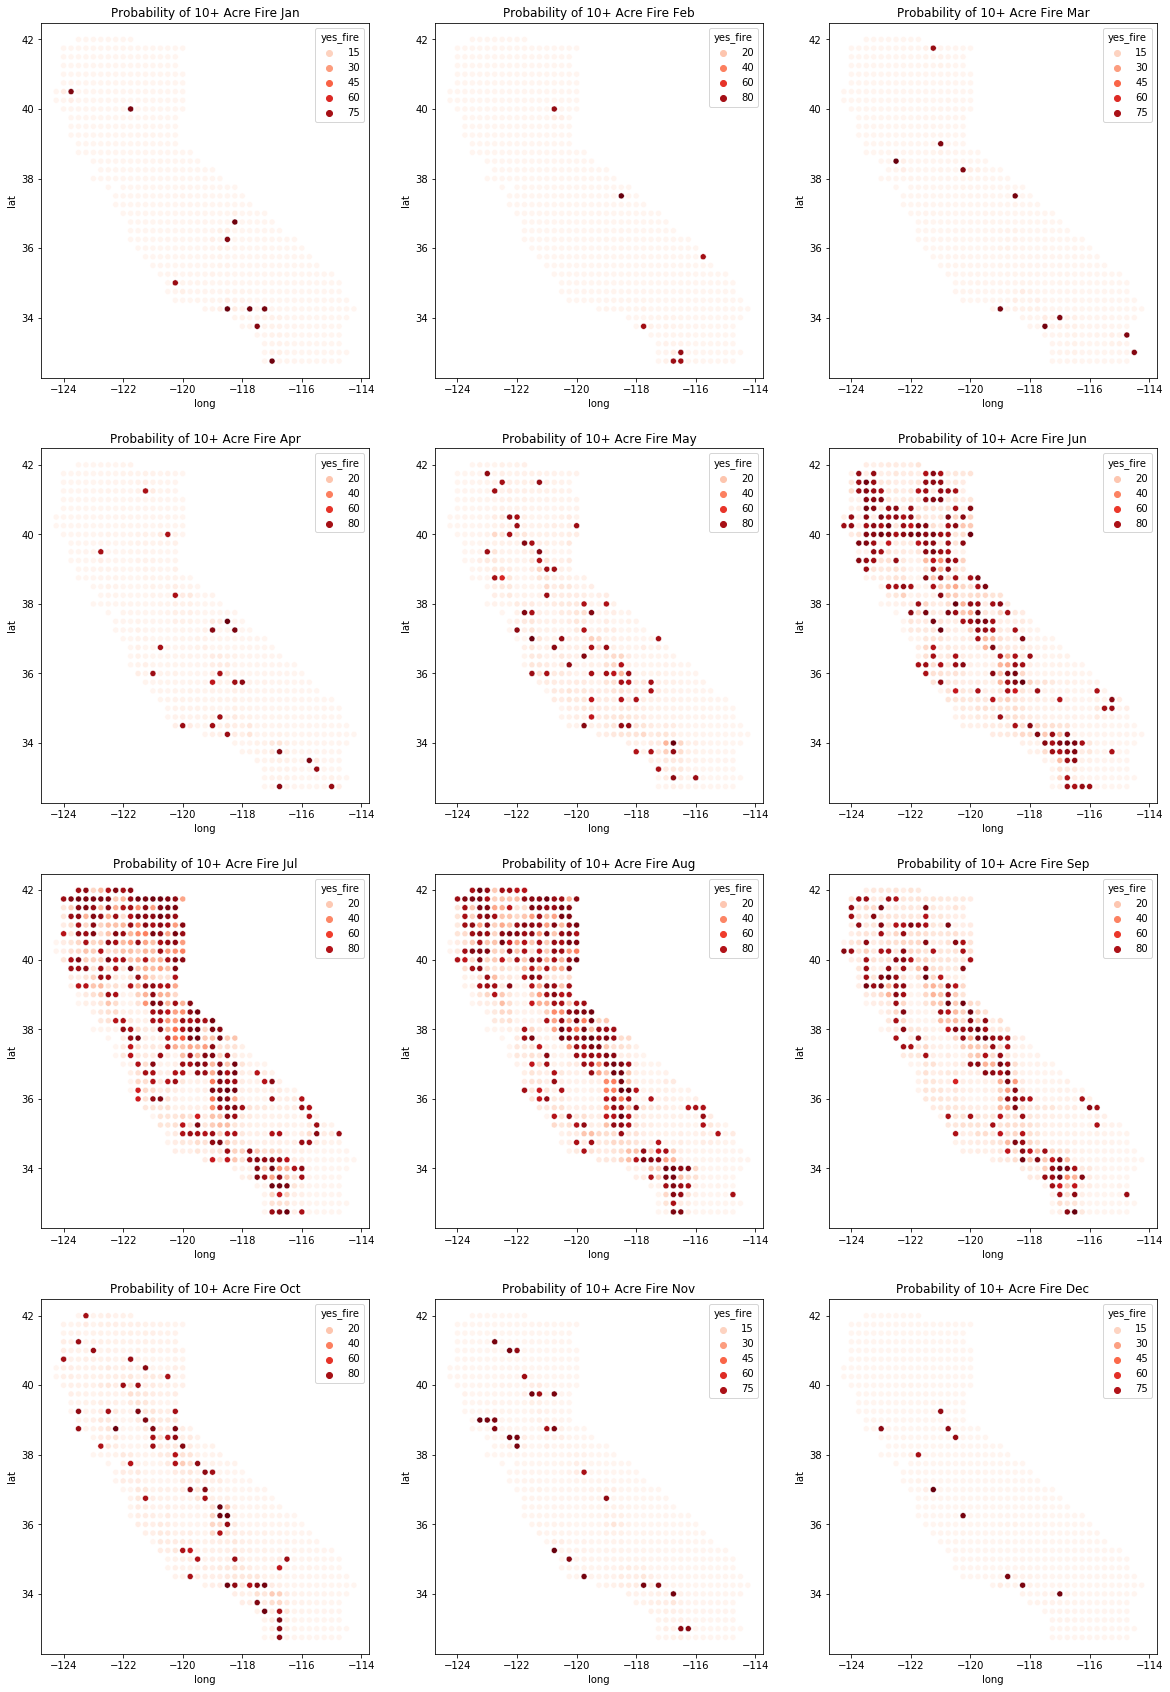

In [25]:
import datetime

X_large_orig_test = train_test_split(df_fires_large, y_large, random_state=42)[1]
X_large_orig_test = X_large_orig_test.reset_index(drop=True)
large_proba_xgb = pd.DataFrame(xgb_large.predict_proba(X_large_test), columns=['no_fire', 'yes_fire'])
large_proba_xgb = pd.concat([X_large_orig_test, large_proba_xgb], axis=1)
large_proba_xgb['yes_fire'] = large_proba_xgb['yes_fire'] * 100
large_proba_xgb = large_proba_xgb.drop(columns=large_proba_xgb.columns.difference(['long', 'lat', 'month', 'yes_fire']))
large_proba_month = large_proba_xgb.groupby(['long', 'lat', 'month']).mean().reset_index()

fig = plt.figure(figsize=(20, 30))

for i in range(1, 13):
    ax = plt.subplot(4, 3, i)
    mon = datetime.datetime.strptime(str(i), "%m").strftime("%b")

    plt.title(f'Probability of 10+ Acre Fire {mon}')
    sns.scatterplot(x='long', y='lat', data=large_proba_month[large_proba_month.month == i],
                    palette='Reds', hue='yes_fire')


In [22]:
import lightgbm as lgb

gbm_large = lgb.LGBMClassifier()

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'learning_rate': [0.01, 0.2, 0.5, 0.8, 1.2],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 2000, 200),
  'max_bin': [200, 300],
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1, 2, 5],
}

gbm_large = RandomizedSearchCV(estimator=gbm_large, param_distributions=params, scoring="recall", cv=3)
gbm_large.fit(X_large_train, y_large_train)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000002
[LightGBM] [Warning] feature_fraction is set=0.7000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000002
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000002
[LightGBM] [Warning] feature_fraction is set=0.7000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000002
[LightGBM] [Warning] bagging_freq is set=2

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'bagging_freq': [1, 2, 5],
                                        'feature_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.01, 0.2, 0.5, 0.8,
                                                          1.2],
                                        'max_bin': [200, 300],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
                                        'num_leaves': [20, 40, 100, 500, 1000,
                                                       5000],
                                  

In [23]:
print(f'Best params: {gbm_large.best_params_}')

y_large_pred_gbm = gbm.predict(X_large_test)

print('--------- LightGBM Classification Report (10+ acre fires) ---------')
print(classification_report(y_large_test, y_large_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 500, 'min_data_in_leaf': 1800, 'metric': 'binary_logloss', 'max_depth': 9, 'max_bin': 200, 'learning_rate': 0.5, 'feature_fraction': 0.7000000000000002, 'bagging_freq': 2, 'bagging_fraction': 0.4000000000000001}
--------- LightGBM Classification Report (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.77      0.84      0.80    227835
        True       0.82      0.75      0.78    228371

    accuracy                           0.79    456206
   macro avg       0.79      0.79      0.79    456206
weighted avg       0.79      0.79      0.79    456206

